📥 Loading dataset...
📋 Loading training features...
Test rows: 643
   ✅ Loaded: top1_AdaBoost.pkl
   ✅ Loaded: top10_KNN.pkl
   ✅ Loaded: top5_ExtraTrees.pkl
   ✅ Loaded: top9_DecisionTree.pkl
   ✅ Loaded: top8_XGBoost.pkl
   ✅ Loaded: top7_SVM.pkl
   ✅ Loaded: top4_RandomForest.pkl
   ✅ Loaded: top2_GradientBoost.pkl
   ✅ Loaded: top3_LogisticRegression.pkl
   ✅ Loaded: top6_LightGBM.pkl

💾 Saving results...
                          model  final_capital  total_return  \
3         top9_DecisionTree.pkl  140566.996573      0.405670   
10                 Buy_and_Hold  138304.862280      0.383049   
2           top5_ExtraTrees.pkl  131669.922213      0.316699   
8   top3_LogisticRegression.pkl  131669.922213      0.316699   
5                  top7_SVM.pkl  131669.922213      0.316699   
1                 top10_KNN.pkl  131330.362291      0.313304   
6         top4_RandomForest.pkl  116370.066304      0.163701   
0             top1_AdaBoost.pkl  102323.049868      0.023230   
7        to

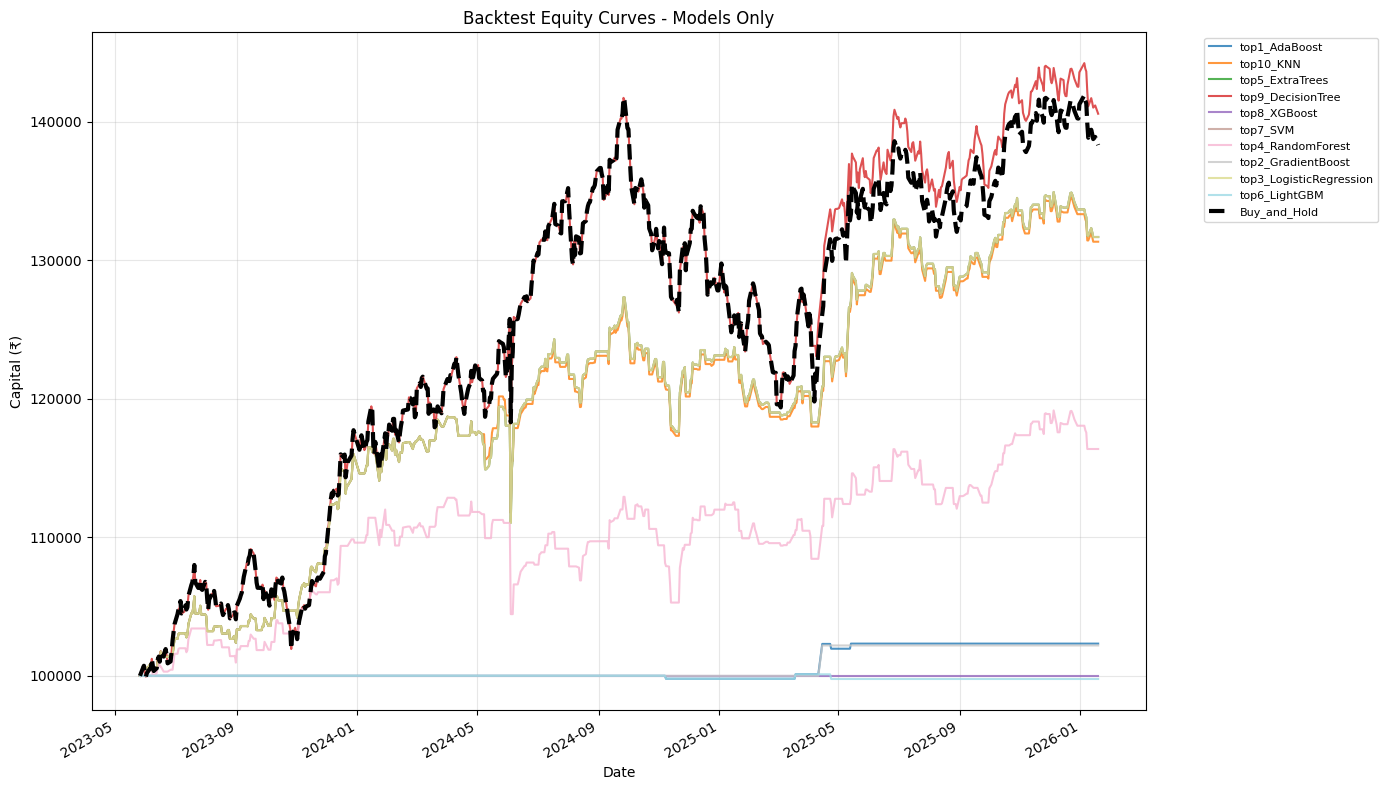


✅ Backtest complete!


In [3]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# ---------------------------
# ✅ User Inputs
# ---------------------------
DATA_PATH = "../data/processed/backtest_ready.csv"
FEATURES_PATH = "../data/processed/best_features.csv"
MODEL_DIR = "../models/"
OUTPUT_DIR = "../trial_backtest"
INITIAL_CAPITAL = 100000.0
CONFIDENCE_THRESHOLD = 0.55

MODELS_TO_TEST = [
    "top1_AdaBoost.pkl",
    "top10_KNN.pkl",
    "top5_ExtraTrees.pkl",
    "top9_DecisionTree.pkl",
    "top8_XGBoost.pkl",
    "top7_SVM.pkl",
    "top4_RandomForest.pkl",
    "top2_GradientBoost.pkl",
    "top3_LogisticRegression.pkl",
    "top6_LightGBM.pkl",
]

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------
# 🧩 Helper Functions
# ---------------------------
def detect_potential_leakage_columns(df):
    suspicious = []
    for col in df.columns:
        if col in ["Date", "NIFTY_50_ret"]:
            suspicious.append(col)
        if col == "NIFTY_50":
            suspicious.append(col)
    return suspicious


def load_selected_models(model_dir, models_to_test=None):
    all_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".pkl")])
    
    if models_to_test is None or len(models_to_test) == 0:
        files_to_load = all_files
        print("📦 Loading ALL models...")
    else:
        files_to_load = []
        for model_name in models_to_test:
            if model_name in all_files:
                files_to_load.append(model_name)
            else:
                print(f"⚠️ Warning: model not found: {model_name}")
        if not files_to_load:
            raise ValueError("❌ None of the selected models found.")
    
    models = {}
    for f in files_to_load:
        try:
            models[f] = joblib.load(os.path.join(model_dir, f))
            print(f"   ✅ Loaded: {f}")
        except Exception as e:
            print(f"   ⚠️ Failed to load {f}: {e}")
    return models


def prepare_test_dataframe(df):
    df = df.iloc[5:]         # ❗ Remove first 5 rows
    n = len(df)
    val_end = int(0.85 * n)
    return df.iloc[val_end:].copy()


def backtest_models_on_test(df_test, models, selected_features, initial_capital, conf_thresh):
    results = {}

    closes = df_test["NIFTY_50"].values
    dates = df_test.index
    n_days = len(df_test)

    for model_name, model in models.items():
        capital = initial_capital
        equity = [capital]
        positions = []
        probs = []
        daily_returns = []

        for i in range(n_days - 1):
            # ✅ FIX: keep DataFrame with feature names
            X_row = df_test[selected_features].iloc[i:i+1]

            try:
                if hasattr(model, "predict_proba"):
                    prob_up = model.predict_proba(X_row)[0][1]
                else:
                    prob_up = float(model.predict(X_row)[0])
            except:
                prob_up = 0.0

            probs.append(prob_up)

            if prob_up >= conf_thresh:
                ret = (closes[i+1] / closes[i]) - 1.0
                capital *= (1 + ret)
                positions.append(1)
                daily_returns.append(ret)
            else:
                positions.append(0)

            equity.append(capital)

        equity_series = pd.Series(equity[:n_days], index=dates)

        positions_array = np.array(positions)
        days_traded = np.sum(positions_array == 1)
        days_no_trade = np.sum(positions_array == 0)

        returns_array = np.array(daily_returns)
        winning_days = np.sum(returns_array > 0)
        losing_days = np.sum(returns_array < 0)
        breakeven_days = np.sum(returns_array == 0)

        win_rate = (winning_days / days_traded * 100) if days_traded > 0 else 0
        loss_rate = (losing_days / days_traded * 100) if days_traded > 0 else 0

        results[model_name] = {
            "equity": equity_series,
            "final_capital": capital,
            "probs": pd.Series(probs, index=dates[:len(probs)]),
            "positions": pd.Series(positions, index=dates[:len(positions)]),
            "days_traded": days_traded,
            "days_no_trade": days_no_trade,
            "winning_days": winning_days,
            "losing_days": losing_days,
            "breakeven_days": breakeven_days,
            "win_rate": win_rate,
            "loss_rate": loss_rate
        }

    return results


def buy_and_hold(df_test, initial_capital):
    closes = df_test["NIFTY_50"].values
    equity = initial_capital * (closes / closes[0])
    final_cap = equity[-1]
    return {"equity": pd.Series(equity, index=df_test.index), "final_capital": final_cap}


# ---------------------------
# 🚀 MAIN SCRIPT
# ---------------------------
print("📥 Loading dataset...")
df = pd.read_csv(DATA_PATH, parse_dates=["Date"], index_col="Date")

df = df.iloc[5:]   # ❗ Drop first 5 days

print("📋 Loading training features...")
best_feats_df = pd.read_csv(FEATURES_PATH, nrows=0)
training_features = best_feats_df.columns.tolist()

EXCLUDE_COLUMNS = ['NIFTY_50_ret', 'Date', 'NIFTY_50', 'target', 'label']
selected_features = [f for f in training_features if f not in EXCLUDE_COLUMNS]

missing_feats = [f for f in selected_features if f not in df.columns]
if missing_feats:
    raise KeyError(f"Missing features: {missing_feats}")

df_test = prepare_test_dataframe(df)
print(f"Test rows: {len(df_test)}")

models = load_selected_models(MODEL_DIR, MODELS_TO_TEST)
bt_results = backtest_models_on_test(df_test, models, selected_features, INITIAL_CAPITAL, CONFIDENCE_THRESHOLD)
bah = buy_and_hold(df_test, INITIAL_CAPITAL)

print("\n💾 Saving results...")

summary = []
for name, res in bt_results.items():
    eq = res["equity"]
    eq.to_csv(os.path.join(OUTPUT_DIR, f"{name}_equity.csv"))
    final = res["final_capital"]
    total_ret = final / INITIAL_CAPITAL - 1
    days = len(eq)
    annualized = (1 + total_ret) ** (252 / max(days, 1)) - 1

    summary.append({
        "model": name,
        "final_capital": final,
        "total_return": total_ret,
        "annualized_return": annualized,
        "days_traded": res["days_traded"],
        "days_no_trade": res["days_no_trade"],
        "winning_days": res["winning_days"],
        "losing_days": res["losing_days"],
        "breakeven_days": res["breakeven_days"],
        "win_rate": res["win_rate"],
        "loss_rate": res["loss_rate"],
    })

# Buy & Hold
bah["equity"].to_csv(os.path.join(OUTPUT_DIR, "buy_and_hold_equity.csv"))
summary.append({
    "model": "Buy_and_Hold",
    "final_capital": bah["final_capital"],
    "total_return": bah["final_capital"]/INITIAL_CAPITAL - 1,
    "annualized_return": 0,
    "days_traded": len(df_test) - 1,
    "days_no_trade": 0,
    "winning_days": 0,
    "losing_days": 0,
    "breakeven_days": 0,
    "win_rate": 0,
    "loss_rate": 0,
})

summary_df = pd.DataFrame(summary).sort_values("final_capital", ascending=False)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "backtest_summary.csv"), index=False)

print(summary_df)

# 📉 Plot ONLY individual models + BAH (no ensemble)
plt.figure(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(bt_results)))

for idx, (name, res) in enumerate(bt_results.items()):
    res["equity"].rename(name.replace(".pkl", "")).plot(color=colors[idx], alpha=0.8)

bah["equity"].rename("Buy_and_Hold").plot(lw=3, ls="--", color="black")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Backtest Equity Curves - Models Only")
plt.xlabel("Date")
plt.ylabel("Capital (₹)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "equity_curves_all_models.png"), dpi=150)
plt.show()

print("\n✅ Backtest complete!")
